# Calculate features from c3d data

> Marcos Duarte  
> [Laboratory of Biomechanics and Motor Control](http://demotu.org/)  
> Federal University of ABC, Brazil

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Helping-functions" data-toc-modified-id="Helping-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Helping functions</a></span></li><li><span><a href="#Data-files" data-toc-modified-id="Data-files-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data files</a></span></li><li><span><a href="#Data-processing" data-toc-modified-id="Data-processing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data processing</a></span><ul class="toc-item"><li><span><a href="#Data-naming-convention" data-toc-modified-id="Data-naming-convention-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data naming convention</a></span></li><li><span><a href="#Example" data-toc-modified-id="Example-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Example</a></span></li><li><span><a href="#All-data" data-toc-modified-id="All-data-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>All data</a></span></li></ul></li></ul></div>

## Python setup

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import glob
import xarray as xr
from tqdm.notebook import tqdm
from pyversions import versions
sys.path.insert(1, r'./../../BMC/functions')
import read_c3d_xr
sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 1.5})
sns.set_style("whitegrid")
xr.set_options(keep_attrs=True)
pd.set_option('display.max_rows', 500)

versions();

Linux 5.4.0-48-generic 64-bit #52-Ubuntu SMP Thu Sep 10 10:58:49 UTC 2020
CPython 3.8.6 packaged by conda-forge (default, Oct  7 2020, 19:08:05) [GCC 7.5.0]
Oct 13 2020, 23:06:07

Module           Version
ipython           7.18.1
jupyterlab         2.2.8
matplotlib         3.3.2
notebook           6.1.4
numpy             1.19.2
pandas             1.1.3
pyversions         0.0.3
read_c3d_xr        0.0.1
seaborn           0.11.0
xarray            0.16.1


## Helping functions

In [17]:
def get_all_features(fname, show=True):
    """
    """
    fname0 = os.path.splitext(os.path.basename(fname))[0]
    names = fname0.split('_')
    _, subject, assessment, trial, _ = names
    if assessment == 'T16':
        assessment = 'T08' 

    prm = read_c3d_xr.get_parameters(fname)

    grf = read_c3d_xr.read_c3d(fname, var='GRF', prm=prm)
    events = read_c3d_xr.find_ev_GRFcycle(grf)
    grf = read_c3d_xr.trimmer(grf, evs=events, trim=1)
    grf = read_c3d_xr.normala(grf, method='BW', mass=prm['mass'])
    #grf = read_c3d.normalt(grf, percent=True)
    fgrf = grf_walk_feats(grf, fname0, show=show)

    side = grf.Time.attrs['side']
    features = {'Filename' : prm['filename'],
                'Subject' : subject,
                'Group' : '1' if subject[1:] in groups['1'] else '2',
                'Assessment' : assessment,
                'Trial' : trial,
                'Mass' : prm['mass'] if 'mass' in prm else np.nan,
                'Height' : prm['height'] if 'height' in prm else np.nan,
                'LegLength' : prm['LL'][side] if 'LL' in prm else np.nan,
                'FootLength' : prm['FL'][side] if 'FL' in prm else np.nan,
                'Cadence' : prm['Cadence'] if 'Cadence' in prm else np.nan,
                'Walking Speed' : prm['Walking Speed'] if 'Walking Speed' in prm else np.nan,
                'Stride Time' : prm['Stride Time'] if 'Stride Time' in prm else np.nan,
                'Foot Off' : prm['Foot Off'] if 'Foot Off' in prm else 100,
                'Stride Length' : prm['Stride Length'] if 'Stride Length' in prm else np.nan,
                'Duration' : np.round(events['1'][0]-events['0'][0], 3),
                'Stance Time' : np.nan,
                'Side' : 'L' if events['0'][1][0] == 'L' else 'R',
                'Cycle' : 'stride' if events['1'][1][1:] == 'FS' else 'step',
               }
    features['Stance Time'] = np.round(features['Duration']*features['Foot Off']/100, 3)     

    data = read_c3d_xr.read_c3d(fname, var='Angle', prm=prm)
    data = read_c3d_xr.trimmer(data, events, trim=1)
    #data = read_c3d.normalt(data, percent=True)
    fang = ang_walk_feats(data, fname0, show=show)
    
    data = read_c3d_xr.read_c3d(fname, var='Moment', prm=prm)
    data = read_c3d_xr.trimmer(data, events, trim=1)
    data = read_c3d_xr.normala(data, method='BM', mass=prm['mass'], LL=prm['LL'][side])
    #data = read_c3d.normalt(data, percent=True)
    fmom = mom_walk_feats(data, fname0, show=show)
    
    data = read_c3d_xr.read_c3d(fname, var='Power', prm=prm)
    data = read_c3d_xr.trimmer(data, events, trim=1)
    data = read_c3d_xr.normala(data, method='BM', mass=prm['mass'], LL=prm['LL'][side])
    #data = read_c3d.normalt(data, percent=True)
    fpow  = pow_walk_feats(data, fname0, show=show)
    
    data = read_c3d_xr.read_c3d(fname, var='Angle', prm=prm)
    data = read_c3d_xr.trimmer(data, events, trim=1)
    data2 = read_c3d_xr.read_c3d(fname, var='POINT', prm=prm)
    data2 = read_c3d_xr.trimmer(data2, events, trim=1)
    value = prm['FL'][side]/data2.attrs['units_all']['scale']/100
    data2 = read_c3d_xr.normala(data2, method='', value=value, units='%FootLength')
    #data = read_c3d.normalt(data, percent=True)
    #data2 = read_c3d.normalt(data2, percent=True)
    foxf = oxf_walk_feats(data, data2, fname0, show=show)

    for key in fgrf:
        features.update({key: fgrf[key][0], key+'t': fgrf[key][1]})
    for key in fang:
        features.update({key: fang[key][0], key+'t': fang[key][1]})
    for key in fmom:
        features.update({key: fmom[key][0], key+'t': fmom[key][1]})
    for key in fpow:
        features.update({key: fpow[key][0], key+'t': fpow[key][1]}) 
    for key in foxf:
        features.update({key: foxf[key][0], key+'t': foxf[key][1]})     

    return features


def get_feature(y, feature='am', ini=0, end=0, freq=1, endpoint=True,
                atleast2=True):
    """Returns feature in `y`[`ini`:`end`+1] and index (instant) when feasible.
    
    Possible features:
    'am': amplitude (value) at `ini`
    'pk': peak (maximum) at `ini`:`end`
    'vl': valley (minimum) at `ini`:`end`
    'me': mean at `ini`:`end`
    'md': median at `ini`:`end` 
    'sd': standard devation at `ini`:`end`
    'rs': root mean square at `ini`:`end`
    'rn': range at `ini`:`end`
    'rt': rate (derivative) at `ini`:`end`
    'it': total integral (area) at `ini`:`end` 
    'ip': positive integral (positive area) at `ini`:`end`
    'in': negative integral (negative area) at `ini`:`end`
    
    """
    import numpy as np

    axis = 0
    if np.isnan(ini) or np.isnan(end):
        return np.nan, np.nan
    ini, end = int(np.round(ini*freq)), int(np.round(end*freq))
    if end == 0: 
        end = len(y)
    elif endpoint:
        end += 1
    if ini > end or ini >= len(y):
        ini = min([end, len(y)-1])    
    if not np.all(np.isnan(y[ini:end])):
        isatleast2 = (not atleast2) or (len(y[ini:end]) > 1)
        if isinstance(feature, list):
            feats = [get_feature(y, f, ini, end, freq, endpoint, axis) for f in feature]
            value, idx = [f[0] for f in feats], [f[1] for f in feats]
        elif feature == 'am':
            idx = ini
            value, idx = y[idx], idx if freq == 1 else idx/freq
        elif feature in ['pk', 'vl'] and isatleast2:
            fun = np.nanargmax if feature == 'pk' else np.nanargmin
            idx = fun(y[ini:end], axis=axis) + ini
            if y.ndim > 1:
                value = np.take_along_axis(y, np.atleast_2d(idx), axis=axis)
                idx = idx if freq == 1 else idx/freq
            else:            
                value, idx = y[idx], idx if freq == 1 else idx/freq
        elif feature == 'me' and isatleast2:
            value, idx = np.nanmean(y[ini:end], axis=axis), np.nan
        elif feature == 'md' and isatleast2:
            value, idx = np.nanmedian(y[ini:end], axis=axis), np.nan
        elif feature == 'sd' and isatleast2:
            value, idx = np.nanstd(y[ini:end], axis=axis, ddof=-1), np.nan
        elif feature == 'rs' and isatleast2:
            value, idx = np.sqrt(np.nanmean(y[ini:end]**2, axis=axis)), np.nan
        elif feature == 'rn' and isatleast2:
            value, idx = (np.nanmax(y[ini:end], axis=axis) -
                          np.nanmin(y[ini:end], axis=axis), np.nan)
        elif feature == 'rt' and isatleast2:
            end = end if end < len(y) else len(y) - 1
            value, idx = (y[end]-y[ini])/((end-ini)/freq), np.nan
        elif feature == 'it' and isatleast2:
            value, idx = np.trapz(y[ini:end], axis=axis)/freq, np.nan
        elif feature in ['ip', 'in'] and isatleast2:
            fun = np.greater if feature == 'ip' else np.less
            if y.ndim > 1:
                value = np.empty(y.shape[1])
                for c in range(y.shape[1]):
                    value[c] = np.trapz(y[fun(y[ini:end, c], 0), c])
                idx = np.nan
            else:                         
                value, idx = np.trapz(y[fun(y[ini:end], 0)])/freq, np.nan              
        else:
            value, idx = np.nan, np.nan
            
        if isinstance(value, np.ndarray) and not isinstance(idx, np.ndarray):
            idx = np.array([idx]*len(value))
        value = np.squeeze(value)
    else:
        value, idx = np.nan, np.nan
    
    return value, idx


def ang_walk_feats(data, fname=None, show=True):
    """
    """
    ft = {}
    side = data.Time.attrs['side']
    color = {'L': 'r', 'R': 'b'}
    color = {'L': 'k', 'R': 'k'}  
    cs = color[side]
    c2 = 'g'
    freq = data.Time.attrs['rate']
    FO = data.Time.attrs['events'][side+'FO'][0]
    # hip
    var = side+'Hip'
    if var in data.Var.values:
        y = data.sel(Var=var).values
    else:
        #print('Missing variable in data: {}'.format(var))
        y = np.array([[np.nan, np.nan, np.nan]])
    ft['HAmlAMfs'] = get_feature(y[:, 0], 'am', ini=0, end=0, freq=freq) 
    ft['HAmlVLt1'] = get_feature(y[:, 0], 'vl', ini=0, end=FO, freq=freq)
    ft['HAmlAMfo'] = get_feature(y[:, 0], 'am', ini=FO, end=0, freq=freq)                              
    ft['HAmlPKw1'] = get_feature(y[:, 0], 'pk', ini=FO, end=0, freq=freq)
    ft['HAapVLal'] = get_feature(y[:, 1], 'vl', ini=0, end=0, freq=freq)
    ft['HAvtPKw1'] = get_feature(y[:, 2], 'pk', ini=FO, end=0, freq=freq)
    # knee
    var = side+'Knee'
    if var in data.Var.values:
        y = data.sel(Var=var).values
    else:
        #print('Missing variable in data: {}'.format(var))
        y = np.array([[np.nan, np.nan, np.nan]])
    ft['KAmlAMfs'] = get_feature(y[:, 0], 'am', ini=0, end=0, freq=freq)
    ft['KAmlVLt1'] = get_feature(y[:, 0], 'vl', ini=FO/5, end=FO, freq=freq)
    ft['KAmlAMfo'] = get_feature(y[:, 0], 'am', ini=FO, end=0, freq=freq) 
    ft['KAmlPKw1'] = get_feature(y[:, 0], 'pk', ini=FO, end=0, freq=freq)
    ft['KAapPKw1'] = get_feature(y[:, 1], 'pk', ini=FO, end=0, freq=freq)
    # ankle
    var = side+'Ankle'
    if var in data.Var.values:
        y = data.sel(Var=var).values
    else:
        #print('Missing variable in data: {}'.format(var))
        y = np.array([[np.nan, np.nan, np.nan]])
    ft['AAmlRNt1'] = get_feature(y[:, 0], 'rn', ini=0, end=FO, freq=freq)
    ft['AAmlAMfs'] = get_feature(y[:, 0], 'am', ini=0, end=0, freq=freq)
    ft['AAapAMfs'] = get_feature(y[:, 1], 'am', ini=0, end=0, freq=freq)
    ft['AAmlAMfo'] = get_feature(y[:, 0], 'am', ini=FO, end=0, freq=freq) 
    ft['AAapPKt1'] = get_feature(y[:, 1], 'pk', ini=0, end=FO, freq=freq) 
    ft['AAapAMfo'] = get_feature(y[:, 1], 'am', ini=FO, end=0, freq=freq) 
    if show:
        time = data.Time.values
        v = [side + ang for ang in ['Hip', 'Knee', 'Ankle']]
        v = [x for x in v if x in data.Var.values]
        g = data.sel(Var=v).plot.line(x='Time', row='Var', col='Axis', sharey=False,
                                      size=2.5, aspect=1.5, color=cs)
        read_c3d_xr.plot_lines(g.axes, data.Time.attrs['events'], show=False)
            
        j = {'H':0, 'K':1, 'A':2}
        a = {'ml':0, 'ap':1, 'vt':2}
        axs = g.axes
        for f in ft:
            if not np.isnan(ft[f][0]) and not np.isnan(ft[f][1]):
                axs[j[f[0]], a[f[2:4]]].plot(ft[f][1], ft[f][0], c2+'o')
                dy = .05 if np.sign(ft[f][0]) > 0 and f[4:6]!='VL' else -.1
                dy = dy*np.diff(axs[j[f[0]], a[f[2:4]]].get_ylim())
                axs[j[f[0]], a[f[2:4]]].text(ft[f][1], ft[f][0]+dy, f[4:], color=c2,
                                             horizontalalignment='center',
                                             bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=.6))
        if axs.shape[0] == 3:
            axs[2, 0].annotate('', (FO/2, np.nanmin(y[:, 0])), (FO/2, np.nanmax(y[:, 0])),
                               arrowprops={'arrowstyle':'<->', 'color':c2, 'ls':'--', 'lw': 1,
                                        'shrinkA':0, 'shrinkB':0})
            axs[2, 0].text(FO/2, np.nanmin(y[:, 0])+ft['AAmlRNt1'][0]/2, 'RNt1',
                           horizontalalignment='center', color=c2,
                           bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=.6))                

        if fname:
            g.fig.suptitle('Joint Angles - Trial: {}'.format(fname), fontsize=12, y=.98)        
        plt.tight_layout()
        plt.savefig(os.path.join(path2, 'figures', fname + '_ang.png'))
        #plt.show()        
    
    return ft


def oxf_walk_feats(data, data2, fname=None, show=True):
    """
    """
    #LHFTBA/RHFTBA Hindfoot with respect to tibia angles
    #LFFHFA/RFFHFA Forefoot with respect to hindfoot angles (Rotação entre antepé e retropé)
    #LHXFFA/RHXFFA Hallux with respect to forefoot dorsiflexion only
    #LFFTBA/RFFTBA Forefoot with respect tibia angles
    #LFTA/RFTA Foot progression angles
    
    ft = {}
    side = data.Time.attrs['side']
    color = {'L': 'r', 'R': 'b'}
    color = {'L': 'k', 'R': 'k'}  
    cs = color[side]
    c2 = 'g'
    freq = data.Time.attrs['rate']
    FO = data.Time.attrs['events'][side+'FO'][0]
    # features
    fs = ['am', 'vl', 'pk', 'rn']
    interval = np.array([[0, 1.0], [1, data.Time.values[-1]/FO]]) * FO    
    intervnm = ['t1', 'w1', 'fs', 'fo']
    # variables
    variables = [side + v for v in ['HFTBA', 'FFHFA', 'FFTBA', 'HXFFA', 'ArchHeightIndex', 'FTA']]
    joints = ['T', 'L', 'F', 'M', 'C', 'P']  # joints
    for v, var in enumerate(variables):
        for a, axis in enumerate(data.Axis.values):
            for i2, i in enumerate(interval):
                for f in fs:
                    if var in data.Var.values:
                        y = data.sel(Var=var).values
                    elif var in data2.Var.values:
                        y = data2.sel(Var=var).values
                    else:
                        #print('Missing variable in data: {}'.format(var))
                        y = np.array([[np.nan, np.nan, np.nan]])
                    if (v == 3 and a > 0) or (v == 4 and a < 2) or (v == 5 and a < 2):
                        continue
                    v2 = 'L' if (v == 4 and a == 2) else 'A'
                    i2i = 2 if f == 'am' else 0
                    key = joints[v] + v2 + axis.lower() + f.upper() + intervnm[i2+i2i]
                    ft[key] = get_feature(y[:, a], f, ini=i[0], end=i[1], freq=freq)

    v = [side + ang for ang in ['HFTBA', 'FFHFA', 'FFTBA', 'HXFFA']]
    v = [x for x in v if x in data.Var.values]
    if show and len(v)==4:
        time = data.Time.values

        g = data.sel(Var=v).plot.line(x='Time', row='Var', col='Axis', sharey=False,
                                      size=2.5, aspect=1.5, color=cs)      
        axs = g.axes.flatten()
        read_c3d_xr.plot_lines(g.axes, data.Time.attrs['events'], show=False)

        axs[9].annotate('Var = {}'.format(v[-1]), xy=(1.02, 0.5), xycoords="axes fraction",
                        rotation=270, ha="left", va="center")
        v2 = side + 'ArchHeightIndex'
        axs[10].clear()
        axs[10].plot(data2.Time.values, data2.sel(Var=v2, Axis='VT'), color=cs)
        read_c3d_xr.plot_lines(axs[10], data.Time.attrs['events'], hline=False, show=False)
        axs[10].set_xlabel('{} [{}]'.format('Time', data.Time.attrs['units']))
        axs[10].set_ylabel('Length [{}]'.format(data2.attrs['units']))
        axs[10].annotate('Var = {}'.format(v2), xy=(1.02, 0.5), xycoords="axes fraction",
                         rotation=270, ha="left", va="center")
        v2 = side + 'FTA'
        axs[11].clear()
        axs[11].plot(data.Time.values, data.sel(Var=v2, Axis='VT'), color=cs)
        read_c3d_xr.plot_lines(axs[11], data.Time.attrs['events'], show=False)
        axs[11].set_xlabel('{} [{}]'.format('Time', data.Time.attrs['units']))
        axs[11].set_ylabel('{} [{}]'.format(data.name, data.attrs['units']))
        axs[11].annotate('Var = {}'.format(v2), xy=(1.02, 0.5), xycoords="axes fraction",
                         rotation=270, ha="left", va="center")
        
        j = {'T':0, 'L':1, 'F': 2, 'M':3, 'C':3, 'P': 3}
        a = {'ml':0, 'ap':1, 'vt':2}
        x0s = interval[:, 0] + np.diff(interval).squeeze()/2
        axs = g.axes
        read_c3d_xr.plot_lines(axs[-1, -1], data.Time.attrs['events'], show=False)
        for f in ft:
            if not np.isnan(ft[f][0]) and f[4:6] in ['RN']:
                if f[0] == 'M' and f[2:4] != 'ml':
                    continue
                if f[0] == 'C' and f[2:4] != 'vt':
                    continue
                if f[0] == 'P' and f[2:4] != 'vt':
                    continue

                x0 = x0s[intervnm.index(f[-2:])]
                if f[0] == 'C':
                    y = data2.sel(Var=var).values
                elif var in data.Var.values:
                    y = data.sel(Var=var).values
                mini = ft[f[:4]+'VL'+f[6:]][0]
                maxi = ft[f[:4]+'PK'+f[6:]][0]
                if f[0] == 'C' and f[2:4] == 'vt':
                    axs[3, 1].annotate('', (x0, mini), (x0, maxi),
                                                     arrowprops={'arrowstyle':'<->', 'color':c2,
                                                                 'ls':'--', 'lw': 1, 'shrinkA':0,
                                                                 'shrinkB':0})
                    axs[3, 1].text(x0, mini+ft[f][0]/2, f[4:],
                                                 horizontalalignment='center', color=c2,
                                                 bbox=dict(facecolor='white', edgecolor='none',
                                                           pad=0, alpha=.7))                   
                else:
                    axs[j[f[0]], a[f[2:4]]].annotate('', (x0, mini), (x0, maxi),
                                                     arrowprops={'arrowstyle':'<->', 'color':c2,
                                                                 'ls':'--', 'lw': 1, 'shrinkA':0,
                                                                 'shrinkB':0})
                    axs[j[f[0]], a[f[2:4]]].text(x0, mini+ft[f][0]/2, f[4:],
                                                 horizontalalignment='center', color=c2,
                                                 bbox=dict(facecolor='white', edgecolor='none',
                                                           pad=0, alpha=.7))                   
            elif not np.isnan(ft[f][0]) and not np.isnan(ft[f][1]) and f[4:6] in ['AM']:
                if f[0] == 'C' and f[2:4] == 'vt':        
                    axs[3, 1].plot(ft[f][1], ft[f][0], c2+'o')                  
                    dy = .05 if np.sign(ft[f][0]) > 0 and f[4:6]!='VL' else -.1
                    dy = dy*np.diff(axs[3, 1].get_ylim())
                    axs[3, 1].text(ft[f][1], ft[f][0]+dy, f[4:], color=c2,
                                                 horizontalalignment='center',
                                                 bbox=dict(facecolor='white', edgecolor='none',
                                                           pad=0, alpha=.7))                  
                else:
                    axs[j[f[0]], a[f[2:4]]].plot(ft[f][1], ft[f][0], c2+'o')                  
                    dy = .05 if np.sign(ft[f][0]) > 0 and f[4:6]!='VL' else -.1
                    dy = dy*np.diff(axs[j[f[0]], a[f[2:4]]].get_ylim())
                    axs[j[f[0]], a[f[2:4]]].text(ft[f][1], ft[f][0]+dy, f[4:], color=c2,
                                                 horizontalalignment='center',
                                                 bbox=dict(facecolor='white', edgecolor='none',
                                                           pad=0, alpha=.7))  

        #axs[3, 1].set_visible(False)
        
        if fname:
            g.fig.suptitle('Oxford Foot Model - Trial: {}'.format(fname), fontsize=12, y=.99)
        plt.tight_layout()
        plt.savefig(os.path.join(path2, 'figures', fname + '_oxf.png'))
        #plt.show() 
    
    return ft


def mom_walk_feats(data, fname=None, show=True):
    """
    """
    ft = {}
    side = data.Time.attrs['side']
    color = {'L': 'r', 'R': 'b'}
    color = {'L': 'k', 'R': 'k'}  
    cs = color[side]
    c2 = 'g'
    freq = data.Time.attrs['rate']
    FO = data.Time.attrs['events'][side+'FO'][0]
    # hip
    var = side+'Hip'
    if var in data.Var.values:
        y = data.sel(Var=var).values
    else:
        #print('Missing variable in data: {}'.format(var))
        y = np.array([[np.nan, np.nan, np.nan]])
    ft['HMmlAMfs'] = get_feature(y[:, 0], 'am', ini=0, end=0, freq=freq)
    ft['HMmlVLt1'] = get_feature(y[:, 0], 'vl', ini=FO/2, end=FO, freq=freq)
    ft['HMmlAMfo'] = get_feature(y[:, 0], 'am', ini=FO, end=0, freq=freq)
    # knee
    var = side+'Knee'
    if var in data.Var.values:
        y = data.sel(Var=var).values
    else:
        #print('Missing variable in data: {}'.format(var))
        y = np.array([[np.nan, np.nan, np.nan]])
    ft['KMmlPKt1'] = get_feature(y[:, 0], 'pk', ini=0, end=FO/2, freq=freq)
    ft['KMmlVLt1'] = get_feature(y[:, 0], 'vl', ini=FO/2, end=FO, freq=freq)
    ft['KMmlAMfo'] = get_feature(y[:, 0], 'am', ini=FO, end=0, freq=freq)
    # ankle
    var = side+'Ankle'
    if var in data.Var.values:
        y = data.sel(Var=var).values
    else:
        #print('Missing variable in data: {}'.format(var))
        y = np.array([[np.nan, np.nan, np.nan]])
    ft['AMmlAMfs'] = get_feature(y[:, 0], 'am', ini=0, end=0, freq=freq)
    ft['AMmlPKt1'] = get_feature(y[:, 0], 'pk', ini=0, end=FO, freq=freq)
    if show:
        time = data.Time.values
        v = [side + ang for ang in ['Hip', 'Knee', 'Ankle']]
        v = [x for x in v if x in data.Var.values]
        g = data.sel(Var=v).plot.line(x='Time', row='Var', col='Axis', sharey=False,
                                      size=2.5, aspect=1.5, color=cs)
        read_c3d_xr.plot_lines(g.axes, data.Time.attrs['events'], show=False)
            
        j = {'H':0, 'K':1, 'A':2}
        a = {'ml':0, 'ap':1, 'vt':2}
        axs = g.axes
        for f in ft:
            if not np.isnan(ft[f][0]) and not np.isnan(ft[f][1]):
                print()
                axs[j[f[0]], a[f[2:4]]].plot(ft[f][1], ft[f][0], c2+'o') 
                dy = .05 if np.sign(ft[f][0]) > 0 and f[4:6]!='VL' else -.1
                dy = dy*np.diff(axs[j[f[0]], a[f[2:4]]].get_ylim())
                axs[j[f[0]], a[f[2:4]]].text(ft[f][1], ft[f][0]+dy, f[4:], color=c2,
                                             horizontalalignment='center',
                                             bbox=dict(facecolor='white', edgecolor='none',
                                                       pad=0, alpha=.6))
                
        if fname:
            g.fig.suptitle('Joint Moment of Forces - Trial: {}'.format(fname), fontsize=12, y=.98)  
        plt.tight_layout()
        plt.savefig(os.path.join(path2, 'figures', fname + '_mom.png'))
        #plt.show()
        
    return ft

    
def pow_walk_feats(data, fname=None, show=True):
    """
    """
    ft = {}
    side = data.Time.attrs['side']
    color = {'L': 'r', 'R': 'b'}
    color = {'L': 'k', 'R': 'k'}  
    cs = color[side]
    c2 = 'g'
    freq = data.Time.attrs['rate']
    FO = data.Time.attrs['events'][side+'FO'][0]
    # ankle
    var = side+'Ankle'
    if var in data.Var.values:
        y = data.sel(Var=var).values
    else:
        #print('Missing variable in data: {}'.format(var))
        y = np.array([[np.nan, np.nan, np.nan]])
    ft['APmlPKal'] = get_feature(y[:, 2], 'pk', ini=0, end=0, freq=freq)
    
    if show:
        time = data.Time.values
        v = [side + ang for ang in ['Hip', 'Knee', 'Ankle']]
        v = [x for x in v if x in data.Var.values]
        g = data.sel(Axis=['VT'], Var=v).plot.line(x='Time', row='Axis', col='Var', sharey=False,
                                                   size=3.23, aspect=1.16, color=cs)
        read_c3d_xr.plot_lines(g.axes, data.Time.attrs['events'], show=False)
            
        c = {'H':0, 'K':1, 'A':2}
        r = {'ml':0}
        axs = np.atleast_2d(g.axes)
        for f in ft:
            if not np.isnan(ft[f][1]):
                axs[r[f[2:4]], c[f[0]]].plot(ft[f][1], ft[f][0], c2+'o') 
                dy = .05 if np.sign(ft[f][0]) > 0 and f[4:6]!='VL' else -.1
                dy = dy*np.diff(axs[r[f[2:4]], c[f[0]]].get_ylim())
                axs[r[f[2:4]], c[f[0]]].text(ft[f][1], ft[f][0]+dy, f[4:], color=c2,
                                             horizontalalignment='center',
                                             bbox=dict(facecolor='white', edgecolor='none',
                                                       pad=0, alpha=.6))
        
        if fname:
            g.fig.suptitle('Joint Power @ ML - Trial: {}'.format(fname), fontsize=12, y=.95)  
        plt.tight_layout()
        plt.savefig(os.path.join(path2, 'figures', fname + '_pow.png'))
        #plt.show()   
        
    return ft
    

def grf_walk_feats(data, fname=None, show=True):
    """Calculate features of GRF during walking.
    """
    ft = {}
    side = data.Time.attrs['side']
    color = {'L': 'r', 'R': 'b'}
    color = {'L': 'k', 'R': 'k'}    
    cs = color[side]
    c2 = 'g'
    freq = data.Time.attrs['rate']
    FO = data.Time.attrs['events'][side+'FO'][0]
    units = data.attrs['units']
    # Forces
    var = 'Force1'
    if var in data.Var.values:
        y = data.sel(Var=var).values
    else:
        #print('Missing variable in data: {}'.format(var))
        y = np.array([[np.nan, np.nan, np.nan]])
    Fml, Fap, Fv = y[:, 0], y[:, 1], y[:, 2]
    i0 = 0.1*FO  # to skip first portion of GRF
    half = FO/2
    
    ft['GFvtPKt1'] = get_feature(Fv, 'pk', ini=i0, end=half, freq=freq)
    ft['GFvtPKt2'] = get_feature(Fv, 'pk', ini=half, end=0, freq=freq)
    _, GFvePKt0t = get_feature(Fv - ((Fv[int(i0*freq)]-Fv[0])/i0)*np.arange(0, len(Fv))/freq,
                               'pk', ini=0, end=i0, freq=freq)
    #ft['GFvePKt0'] = (Fv[int(np.round(GFvePKt0t*freq))], GFvePKt0t)
    ft['GFvtPKt0'] = get_feature(Fv, 'am', ini=GFvePKt0t, end=0, freq=freq)
    ft['GFvtVLt1'] = get_feature(Fv, 'vl', ini=ft['GFvtPKt1'][1], end=ft['GFvtPKt2'][1], freq=freq)
    ft['GFapPKt1'] = get_feature(Fap, 'vl', ini=i0, end=half, freq=freq)
    ft['GFapPKt2'] = get_feature(Fap, 'pk', ini=half, end=0, freq=freq) 
    ft['GFvtIPal'] = get_feature(Fv, 'ip', ini=0, end=0, freq=freq)
    
    ft['GFvtRTt0'] = get_feature(Fv, 'rt', ini=0, end=ft['GFvtPKt0'][1], freq=freq)
    ft['GFvtRTt1'] = get_feature(Fv, 'rt', ini=0, end=ft['GFvtPKt1'][1], freq=freq)
    ft['GFapINal'] = get_feature(Fap, 'in', ini=0, end=0, freq=freq)
    ft['GFapIPal'] = get_feature(Fap, 'ip', ini=0, end=0, freq=freq)
    ft['GFapRTt1'] = get_feature(Fap, 'rt', ini=0, end=ft['GFapPKt1'][1], freq=freq)
    
    if show:
        time = data.Time.values
        v = [var]
        v = [x for x in v if x in data.Var.values]
        g = data.sel(Var=v).plot.line(x='Time', row='Var', col='Axis', sharey=False,
                                      size=3.23, aspect=1.16, color=cs)
        read_c3d_xr.plot_lines(g.axes, data.Time.attrs['events'], show=False)
            
        j = {'G':0}
        a = {'ml':0, 'ap':1, 'vt':2}
        axs = g.axes
        for f in ft:
            if not np.isnan(ft[f][1]):
                axs[j[f[0]], a[f[2:4]]].plot(ft[f][1], ft[f][0], c2+'o') 
                dy = .05 if np.sign(ft[f][0]) > 0 and f[4:6]!='VL' else -.1
                dy = dy*np.diff(axs[j[f[0]], a[f[2:4]]].get_ylim())
                axs[j[f[0]], a[f[2:4]]].text(ft[f][1], ft[f][0]+dy, f[4:], color=c2,
                                             horizontalalignment='center',
                                             bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=.6))

        axs[0, 1].fill_between(time[Fap<0], 0, Fap[Fap<0], hatch=r'\\',
                               fc='none', ec='k', linewidth=0.0)  # color=[1, 0, 0, .2]
        axs[0, 1].fill_between(time[Fap>0], 0, Fap[Fap>0], hatch='//',
                               fc='none', ec='k', linewidth=0.0)  # color=[0, 1, 0, .2]
        if not np.isnan(ft['GFapPKt1'][1]):
            axs[0, 1].plot([0, ft['GFapPKt1'][1]], [0, ft['GFapPKt1'][0]], c=c2, ls=':', lw=2)
            axs[0, 1].text(ft['GFapPKt1'][1], ft['GFapPKt1'][0]*0.4, 'INal',
                           horizontalalignment='center', color=c2,
                           bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=1))  
        if not np.isnan(ft['GFapPKt2'][1]):
            axs[0, 1].text(ft['GFapPKt2'][1], ft['GFapPKt2'][0]*0.3, 'IPal',
                            horizontalalignment='center', color=c2,
                            bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=1))        
        axs[0, 2].fill_between(time[Fv>0], 0, Fv[Fv>0], hatch='//',
                               fc='none', ec='k', linewidth=0.0)
        if not np.isnan(ft['GFvtPKt0'][1]):
            axs[0, 2].plot([0, ft['GFvtPKt0'][1]], [0, ft['GFvtPKt0'][0]], c=c2, ls=':', lw=2)
        if not np.isnan(ft['GFvtPKt1'][1]):
            axs[0, 2].plot([0, ft['GFvtPKt1'][1]], [0, ft['GFvtPKt1'][0]], c=c2, ls=':', lw=2)
            axs[0, 2].axhline(y=0, c='k', lw=0.5)
        if not np.isnan(ft['GFvtVLt1'][1]):
            axs[0, 2].text(ft['GFvtVLt1'][1], ft['GFvtVLt1'][0]*0.3, 'IPal',
                            horizontalalignment='center', color=c2,
                            bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=1))
        if fname:
            g.fig.suptitle('Ground Reaction Forces - Trial: {}'.format(fname),
                           fontsize=12, y=.95)    
        plt.tight_layout()
        plt.savefig(os.path.join(path2, 'figures', fname + '_grf.png'))
        #plt.show()

    return ft


## Data files

In [18]:
path2 = './../../../X/isabel/erica/c3d/'
groups = {'1': ['02', '04', '06', '07', '11', '12', '14', '15', '16'],
          '2': ['01', '03', '05', '08', '09', '10', '13', '17', '18', '19', '20']}
# c3d files in the directory:
filenames = glob.glob(os.path.join(path2, '**', '*.c3d'), recursive=True)
filenames.sort()
print('Number of c3d files:', len(filenames))

Number of c3d files: 320


## Data processing

### Data naming convention

The names of the data follow the convention:  
> `<ABccDDeeF>`

Where:  
 - `<A>`. Joint/Segment: `H` (hip), `K` (knee), `A` (ankle), `F` (foot), `G` (ground), `T` (hindfoot with tibia, tibio-talar), `L` (forefoot with hindfoot, Lisfranc), `F` (forefoot with tibia), `M` (halux with forefoot, MTP), `C` (arch height index), `P` (foot progression);  
 - `<B>`. Variable: `F` (force as GRF), `A` (angle), `M` (moment), `P` (power), `L` (length);  
 - `<cc>`. Axis: `ML` (medio-lateral), `AP` (antero-posterior), `VT` (vertical);  
 - `<DD>`. Feature: `PK` (peak or maximum), `VL` (valley or minimum), `AM` (amplitude or value), `RN` (range), `RT` (rate), `IT` (integral or impluse total, the total area), `IP` (integral or impulse positive, the positive area), `IN` (integral or impulse negative, the negative area);  
 - `<ee>`. Instant: `t` (stance phase), `w` (swing phase), `fs` (foot strike), `fo` (foot off), `al` (all cycle), `c` (rocker), `1`, `2`, `3`... (number of the instant if necessary);  
 - `<f>`. Side: `R` (right), `L` (left), `B` (both), `N` (none).

For now, the side of the body is not important, the valid ones can be from either side.
Thus, the side (item `<f>` above) is not specified in the name of the feature, leaving only `<ABccDDee>`.

### Example

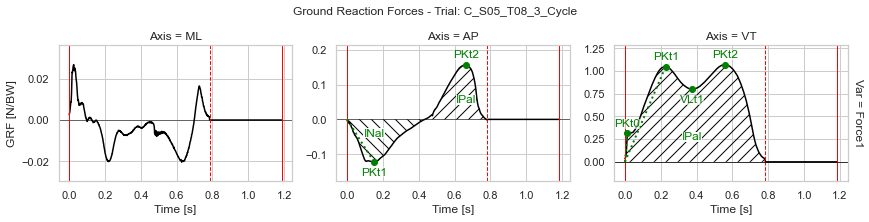

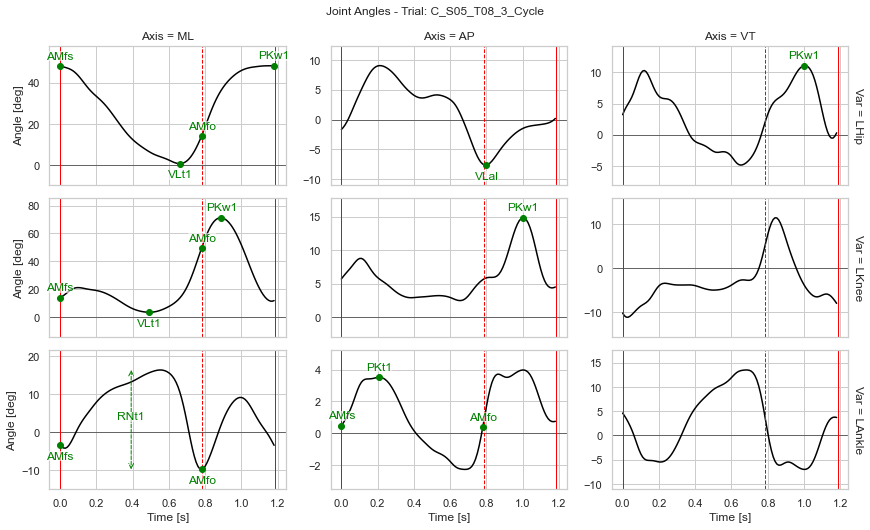

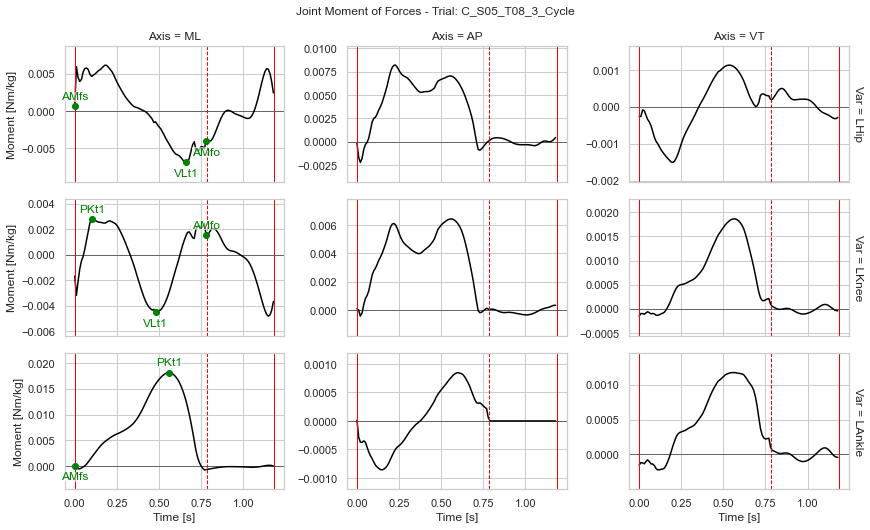

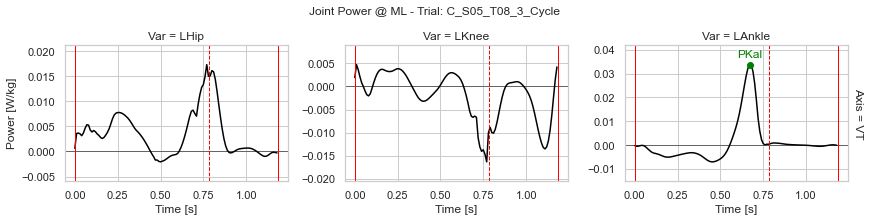

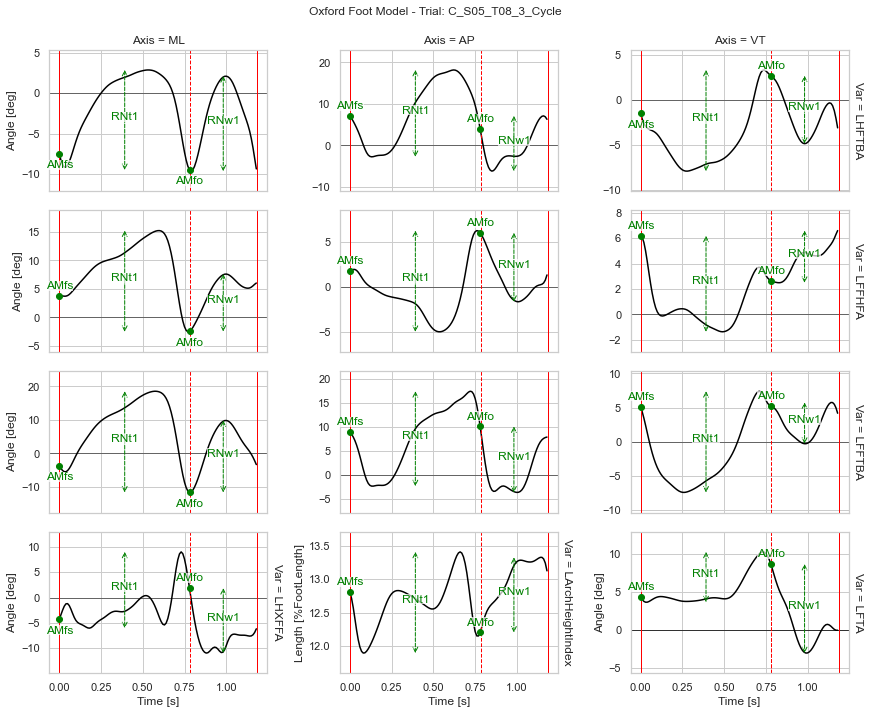

In [21]:
features = get_all_features(filenames[60], show=True)

### All data

In [5]:
df = pd.DataFrame()
for f, fname in enumerate(tqdm(filenames)):
    features = get_all_features(fname, show=False)
    df = df.append(pd.DataFrame(data=features, index=[f]))
    #plt.close('all')

#df.index.name = 'Index'
df.dropna(axis=1, how='all', inplace=True)
df['Trial'] = pd.to_numeric(df['Trial'])
df.sort_values(by=['Group', 'Assessment', 'Subject', 'Trial'],
               ignore_index=True, inplace=True)
          
#df['G'] = df['Group'].astype('category').cat.codes  # categorize by order of label
df['G'] = df['Group'].factorize()[0]  # categorize by order of appearance
df['A'] = df['Assessment'].astype('category').cat.codes
df['S'] = df['Subject'].factorize()[0]
#df['S'] = df['Subject'].astype('category').cat.codes
#df['S'] = df[['Group', 'Subject',
#             ]].groupby(['Group']).transform(lambda x: pd.factorize(x)[0]) 
df['T'] = df[['Group', 'Assessment', 'Subject', 'Trial'
             ]].groupby(['Group', 'Assessment',
                         'Subject']).transform(lambda x: pd.factorize(x)[0])
                
df.to_csv(os.path.join(path2, 'features_all.csv'), na_rep='nan', float_format='%.6f')

In [6]:
df

,Filename,Subject,Group,Assessment,Trial,Mass,Height,LegLength,FootLength,Cadence,...,PAvtAMfot,PAvtVLw1,PAvtVLw1t,PAvtPKw1,PAvtPKw1t,PAvtRNw1,G,A,S,T
0,C_S02_T00_2_Cycle,S02,1,T00,2,85.2,1.60,0.746,0.191,103.448,...,0.70,-23.375893,0.81,-13.211102,1.07,10.164791,0,0,0,0
1,C_S02_T00_4_Cycle,S02,1,T00,4,85.2,1.60,0.810,0.191,103.806,...,0.73,-24.170155,0.87,-10.210148,0.75,13.960007,0,0,0,1
2,C_S02_T00_9_Cycle,S02,1,T00,9,85.2,1.60,0.810,0.191,107.335,...,0.70,-23.864309,0.82,-8.956481,0.72,14.907828,0,0,0,2
3,C_S02_T00_11_Stance,S02,1,T00,11,85.2,1.60,0.746,0.183,NaN,...,0.63,NaN,NaN,NaN,NaN,NaN,0,0,0,3
4,C_S02_T00_12_Cycle,S02,1,T00,12,85.2,1.60,0.810,0.194,0.000,...,0.66,-2.729700,0.66,-2.080230,0.67,0.649470,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,C_S19_T08_7_Cycle,S19,2,T08,7,123.0,1.86,0.874,0.214,120.240,...,0.69,-16.284195,0.79,-7.891533,0.69,8.392662,1,1,19,5
316,C_S19_T08_8_Cycle,S19,2,T08,8,123.0,1.86,0.874,0.214,111.836,...,0.69,-19.627350,0.78,-9.379754,0.69,10.247596,1,1,19,6
317,C_S19_T08_9_Cycle,S19,2,T08,9,123.0,1.86,0.874,0.224,135.135,...,0.69,-15.947328,0.98,-4.942174,0.69,11.005153,1,1,19,7
318,C_S19_T08_10_Cycle,S19,2,T08,10,123.0,1.86,0.874,0.224,123.584,...,0.79,-12.944420,0.91,-1.866431,0.79,11.077989,1,1,19,8


In [9]:
df

,Filename,Subject,Group,Assessment,Trial,Mass,Height,LegLength,FootLength,Cadence,...,PAvtAMfot,PAvtVLw1,PAvtVLw1t,PAvtPKw1,PAvtPKw1t,PAvtRNw1,G,A,S,T
0,C_S02_T00_2_Cycle,S02,1,T00,2,85.2,1.60,0.746,0.191,103.448,...,0.70,-23.375893,0.81,-13.211102,1.07,10.164791,0,0,0,0
1,C_S02_T00_4_Cycle,S02,1,T00,4,85.2,1.60,0.810,0.191,103.806,...,0.73,-24.170155,0.87,-10.210148,0.75,13.960007,0,0,0,1
2,C_S02_T00_9_Cycle,S02,1,T00,9,85.2,1.60,0.810,0.191,107.335,...,0.70,-23.864309,0.82,-8.956481,0.72,14.907828,0,0,0,2
3,C_S02_T00_11_Stance,S02,1,T00,11,85.2,1.60,0.746,0.183,NaN,...,0.63,NaN,NaN,NaN,NaN,NaN,0,0,0,3
4,C_S02_T00_12_Cycle,S02,1,T00,12,85.2,1.60,0.810,0.194,0.000,...,0.66,-2.729700,0.66,-2.080230,0.67,0.649470,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,C_S19_T08_7_Cycle,S19,2,T08,7,123.0,1.86,0.874,0.214,120.240,...,0.69,-16.284195,0.79,-7.891533,0.69,8.392662,1,1,19,5
316,C_S19_T08_8_Cycle,S19,2,T08,8,123.0,1.86,0.874,0.214,111.836,...,0.69,-19.627350,0.78,-9.379754,0.69,10.247596,1,1,19,6
317,C_S19_T08_9_Cycle,S19,2,T08,9,123.0,1.86,0.874,0.224,135.135,...,0.69,-15.947328,0.98,-4.942174,0.69,11.005153,1,1,19,7
318,C_S19_T08_10_Cycle,S19,2,T08,10,123.0,1.86,0.874,0.224,123.584,...,0.79,-12.944420,0.91,-1.866431,0.79,11.077989,1,1,19,8


In [11]:
df[['Group', 'Assessment', 'Subject', 'Trial', 'G', 'A', 'S', 'T', 'Filename']]

,Group,Assessment,Subject,Trial,G,A,S,T,Filename
0,1,T00,S02,2,0,0,0,0,C_S02_T00_2_Cycle
1,1,T00,S02,4,0,0,0,1,C_S02_T00_4_Cycle
2,1,T00,S02,9,0,0,0,2,C_S02_T00_9_Cycle
3,1,T00,S02,11,0,0,0,3,C_S02_T00_11_Stance
4,1,T00,S02,12,0,0,0,4,C_S02_T00_12_Cycle
...,...,...,...,...,...,...,...,...,...
315,2,T08,S19,7,1,1,19,5,C_S19_T08_7_Cycle
316,2,T08,S19,8,1,1,19,6,C_S19_T08_8_Cycle
317,2,T08,S19,9,1,1,19,7,C_S19_T08_9_Cycle
318,2,T08,S19,10,1,1,19,8,C_S19_T08_10_Cycle
